# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

Данные исторические: технические характеристики, комплектации и цены автомобилей. 

**Задача:** построить модель для определения стоимости. Качество модели по метрике RMSE должно быть ниже 2500.

**Описание данных:**

**Признаки**<br>
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**<br>
- Price — цена (евро)

**Ход исследования:**
1. Импорт библиотек
2. Вводный анализ данных
3. Предобработка данных
4. Обучение моделей
5. Анализ моделей
6. Проверка лучшей модели
7. Вывод

## Импорт библиотек

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
import lightgbm as lgb

## Вводный анализ данных

Создам переменную с данными:

In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('D:\\data\\autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Я бы удалила неинформативные колонки: DateCrawled, DateCreated, NumberOfPictures, LastSeen, RegistrationMonth. Эти данные на цену автомобиля напрямую не влияют. Также мне кажется, что колонка PostalCode может быть не важной, но надо посмотреть на частотность значений, проверю это чуть позже.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Формат колонки repaired я бы заменила на bool, предварительно изменив yes на true, а no на false. Но сначала надо посмотреть частотность значений и пропуски, тогда приму решение.

У дат тоже надо изменять формат, но я удалю эти колонки на этапе предобработки. Поэтому менять формат не буду.

In [6]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Посмотрю на разброс значений в столбцах:

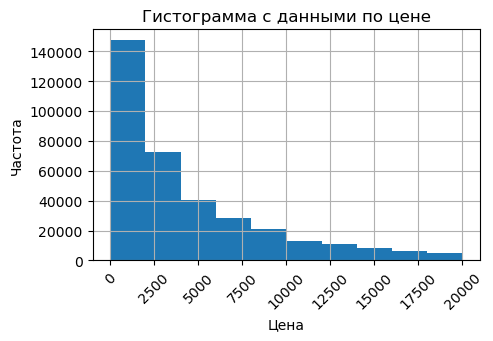

In [5]:
plt.rcParams['figure.figsize'] = [5, 3]

data['Price'].hist()

plt.xlabel("Цена")
plt.ylabel("Частота")
plt.title("Гистограмма с данными по цене")
plt.xticks(rotation = 45);

Чаще всего машины стоят примерно до 2000.

In [6]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Не вижу неявных дубликатов. Если будут пропуски, можно их заменить на other.

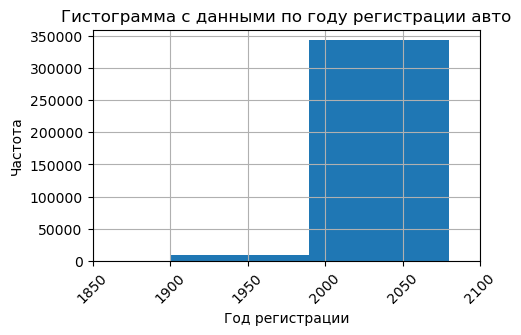

In [7]:
data['RegistrationYear'].hist(bins=100)

plt.xlim([1850, 2100])
plt.ylim([0, 360000])
plt.xlabel("Год регистрации")
plt.ylabel("Частота")
plt.title("Гистограмма с данными по году регистрации авто")
plt.xticks(rotation = 45);

Наверняка есть аномалии, поэтому их нужно будет почистить.

In [8]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Все отлично.

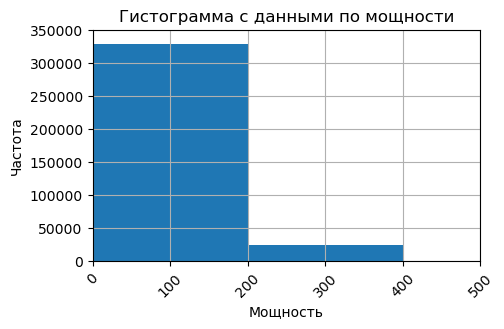

In [9]:
data['Power'].hist(bins=100)

plt.xlim([0, 500])
plt.ylim([0, 350000])
plt.xlabel("Мощность")
plt.ylabel("Частота")
plt.title("Гистограмма с данными по мощности")
plt.xticks(rotation = 45);

Чаше всего мощность до 200 л.с.

In [10]:
data['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

Если будут пропуски, их можно будет заменить на значение "other".

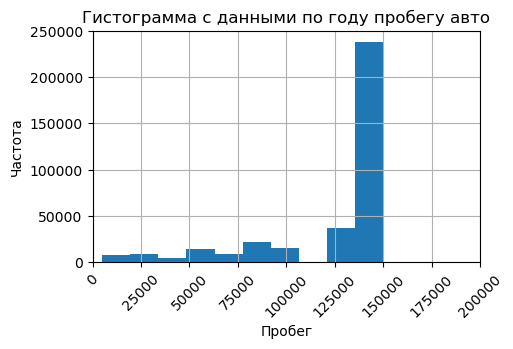

In [11]:
data['Kilometer'].hist(bins=10)

plt.xlim([0, 200000])
plt.ylim([0, 250000])
plt.xlabel("Пробег")
plt.ylabel("Частота")
plt.title("Гистограмма с данными по году пробегу авто")
plt.xticks(rotation = 45);

Чаще всего пробег от 130 до 150 тысяч.

In [12]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Все отлично.

In [13]:
data['Brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

Все отлично.

In [14]:
data['Repaired'].value_counts()

no     247161
yes     36054
Name: Repaired, dtype: int64

Если есть пропуски, придется добавить еще одно значение.

In [15]:
data['PostalCode'].value_counts()

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
91801      1
31097      1
82444      1
94359      1
31096      1
Name: PostalCode, Length: 8143, dtype: int64

Это колонка кажется не важной, частотность не высокая, вряд ли как-то повлияет на цену.

Проверю данные на пропуски:

In [16]:
print("Количество пропусков:")
data.isna().sum()

Количество пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Как заполнить пропуски:
    
- VehicleType - можно заполнить NaN значением other
- Gearbox - можно заменить NaN на unknown
- Model - можно заполнить NaN значением other
- FuelType - можно заполнить NaN значением other
- Repaired - можно заполнить NaN значением unknown

Проверю, есть ли дубликаты строк:

In [17]:
print("Количество дубликатов:", data.duplicated().sum())

Количество дубликатов: 4


Проверю аномалии в колонках:

**Price**

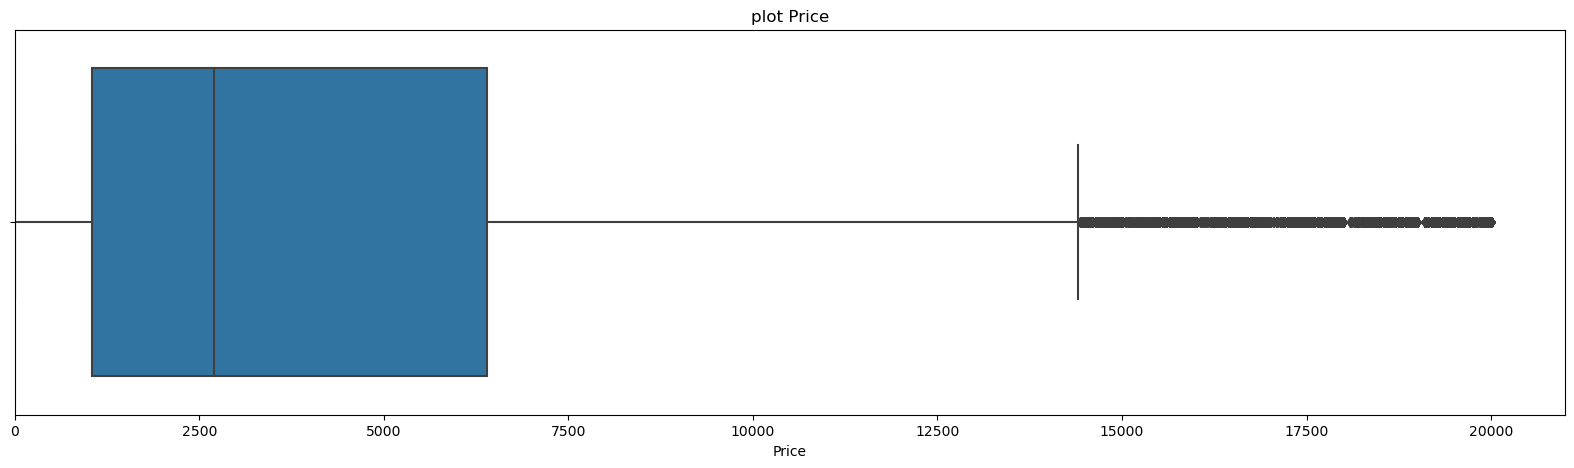

In [18]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=data, x='Price')
ax.set_xlim(0, 21000)
ax.set_title("plot Price");

In [19]:
print('Min:', data['Price'].min())
print('Mean:', data['Price'].mean())
print('Median:', data['Price'].median())
print('Max:', data['Price'].max())

Min: 0
Mean: 4416.656775846645
Median: 2700.0
Max: 20000


Есть нули в значениях.Сколько их:

In [20]:
data.query('Price == 0')['Price'].count()

10772

Видно, что есть выбросы после 14000 евро. Но это вполне вероятно просто новые и дорогие машины, это может быть важным для обучения модели. К тому же значения выбросов (14000-20000) не выглядят странными. Поэтому я заменю нули на медиану по цене, а значения больше 14000 трогать не буду.

**RegistrationYear**

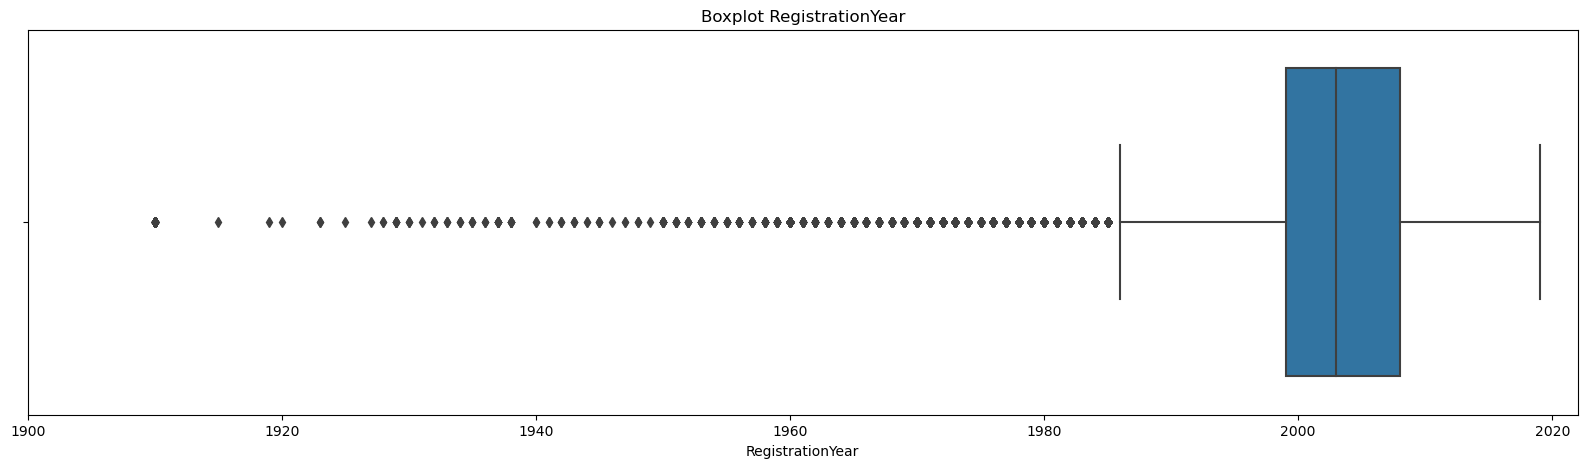

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=data, x='RegistrationYear')
ax.set_xlim(1900, 2022)
ax.set_title("Boxplot RegistrationYear");

Сколько выбросов до 1985 года:

In [22]:
data.query('RegistrationYear < 1985')['RegistrationYear'].count()

5448

In [23]:
print('Min:', data['RegistrationYear'].min())
print('Mean:', data['RegistrationYear'].mean())
print('Median:', data['RegistrationYear'].median())
print('Max:', data['RegistrationYear'].max())

Min: 1000
Mean: 2004.234447708462
Median: 2003.0
Max: 9999


Проверю, сколько значений со значением больше текущего года 2023:

In [24]:
data.query('RegistrationYear > 2023')['RegistrationYear'].count()

105

Эти аномалии я удалю (их не много) - год регистрации до 1985 и больше 2023.

**Power**

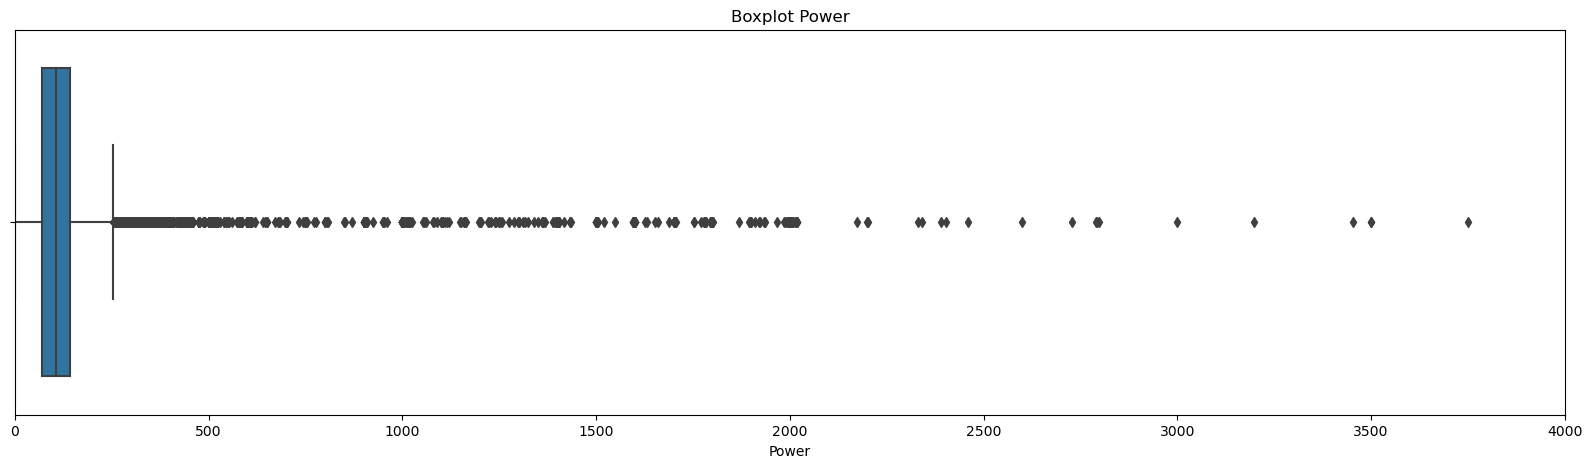

In [25]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=data, x='Power')
ax.set_xlim(0, 4000)
ax.set_title("Boxplot Power");

In [26]:
print('Min:', data['Power'].min())
print('Mean:', data['Power'].mean())
print('Median:', data['Power'].median())
print('Max:', data['Power'].max())

Min: 0
Mean: 110.0943366942368
Median: 105.0
Max: 20000


Сколько значений 0:

In [27]:
data.query('Power == 0')['Power'].count()

40225

Сколько значений больше 1000:

In [28]:
data.query('Power > 1000')['Power'].count()

302

Выбросы нули и от 250 л.с. Но я приняла решение убрать только мощность больше 1000 л.с., так как у машин вполне может быть мощность до 1000 л.с. - и неправильным было бы не учить модель принимать во внимание такие признаки. Также нули заменю на медиану по мощности.

**Kilometer**

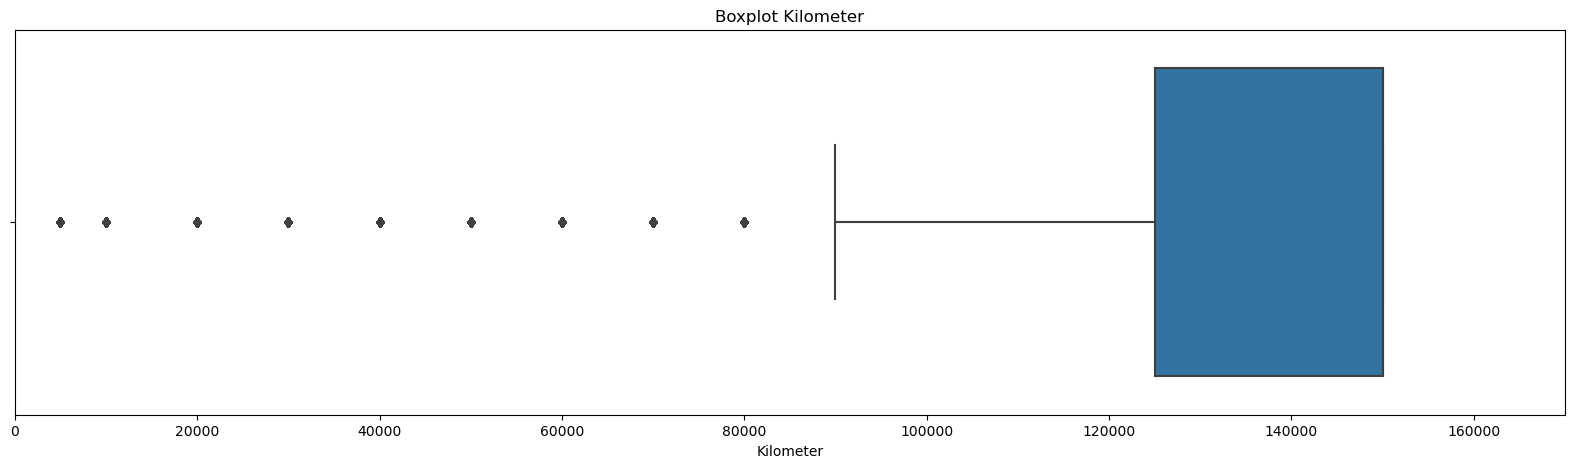

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=data, x='Kilometer')
ax.set_xlim(0, 170000)
ax.set_title("Boxplot Kilometer");

In [30]:
print('Min:', data['Kilometer'].min())
print('Mean:', data['Kilometer'].mean())
print('Median:', data['Kilometer'].median())
print('Max:', data['Kilometer'].max())

Min: 5000
Mean: 128211.17253484363
Median: 150000.0
Max: 150000


Выбросы примерно до 80000:

In [31]:
data.query('Kilometer < 80000')['Kilometer'].count()

43210

Если я удалю выбросы, я не покажу модели новые машины, что не совсем верно. Поэтому их я убирать тоже не буду.

**Промежуточный вывод:** 

1. Я решила удалить колонки: DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen.
2. Также я обнаружила пропуски и дубликаты. Почищу их на этапе предобработки.
3. Есть аномалии - их тоже удалю на этапе предобработки.

## Предобработка данных

### Удаление колонок

In [32]:
data = data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', \
                          'LastSeen'])

### Удаление аномалий

In [33]:
print('Изначальный объем данных:', data.shape[0])

Изначальный объем данных: 354369


**Price**

In [34]:
# Вычисление медианы с группировкой по колонке "Brand"
median_price_by_brand = data[data['Price'] > 0].groupby('Brand')['Price'].median().round(0)


# Замена значений 0 медианой с группировкой по колонке "Brand"
data.loc[data['Price'] == 0, 'Price'] = data.loc[data['Price'] == 0, 'Brand'].map(median_price_by_brand)

In [35]:
#Проверка
data.query('Price == 0')['Power'].count()

0

**RegistrationYear**

In [36]:
data = data.query('RegistrationYear >= 1985 and RegistrationYear < 2023').reset_index(drop=True)

**Power**

In [37]:
# Вычисление медианы с группировкой по колонке "Brand"
median_power_by_brand = data[data['Power'] > 0].groupby('Brand')['Power'].median().round(0)


# Замена значений 0 медианой с группировкой по колонке "Brand"
data.loc[data['Power'] == 0, 'Power'] = data.loc[data['Power'] == 0, 'Brand'].map(median_power_by_brand)

In [38]:
# Проверка
data.query('Power == 0')['Power'].count()

0

Оставляю мощность меньше 1000 л.с.:

In [39]:
data = data.query('Power < 1000').reset_index(drop=True)

Какой объем данных остался:

In [40]:
print('Объем данных после удаление аномалий:', round(data.shape[0] / 354369 * 100, 2), '%')

Объем данных после удаление аномалий: 98.35 %


### Чистка NaN и дубликатов

Как заполнить пропуски:

VehicleType - можно заполнить NaN значением other <br>
Gearbox - можно заменить NaN на unknown <br>
Model - можно заполнить NaN значением other <br>
FuelType - можно заполнить NaN значением other<br>
Repaired - можно заполнить NaN значением unknown<br>

In [41]:
data['VehicleType'].fillna('other', inplace=True)

In [42]:
data['Gearbox'].fillna('unknown', inplace=True)

In [43]:
data['Model'].fillna('other', inplace=True)

In [44]:
data['FuelType'].fillna('other', inplace=True)

In [45]:
data['Repaired'].fillna('unknown', inplace=True)

In [46]:
print("Проверка:")
data.isna().sum()

Проверка:


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [47]:
data.duplicated().sum()

45467

Количество дублей заметно увеличилось, но их все равно стоит удалить, так как они только зря будут грузить модель при обучении.

Удалю дубли:

In [48]:
data = data.drop_duplicates().reset_index(drop=True)

In [49]:
print("Проверка:")
data.duplicated().sum()

Проверка:


0

In [50]:
print('Объем данных после удаление NaN и дублей:', data.shape[0])

Объем данных после удаление NaN и дублей: 303055


In [51]:
print("Осталось", round(303055 / 354369 * 100), '% от изначального объема данных')

Осталось 86 % от изначального объема данных


**Промежуточный вывод:** 

1. Лишние колонки удалены.
2. Аномалии удалены.
3. Пропуски заполнены, дубли удалены.

Проверка:

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303055 entries, 0 to 303054
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             303055 non-null  int64 
 1   VehicleType       303055 non-null  object
 2   RegistrationYear  303055 non-null  int64 
 3   Gearbox           303055 non-null  object
 4   Power             303055 non-null  int64 
 5   Model             303055 non-null  object
 6   Kilometer         303055 non-null  int64 
 7   FuelType          303055 non-null  object
 8   Brand             303055 non-null  object
 9   Repaired          303055 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.1+ MB


## Подготовка выборки для обучения

### Прямое кодирование данных и стандартизация, разбивка на выборки

**Разделение на фичерс и таргет:**

In [53]:
target = data['Price']
features = data.drop('Price', axis='columns')

**Разобью данные на тренировочную, тестовую и валидационную выборки: 60%, 20% и 20%.**

In [54]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=123)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=123)

print(features_train.shape, features_valid.shape, features_test.shape) #проверка размера выборок
print(target_train.shape, target_valid.shape, target_test.shape)

(181833, 9) (60611, 9) (60611, 9)
(181833,) (60611,) (60611,)


**Стандартизация:**

In [55]:
pd.options.mode.chained_assignment = None

# Определение числовых столбцов
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Кодировка LabelEncoder для Random Forest Regressor:**

Создам отдельные выборки, так как с ними я буду работать немного иначе, чем с данными для бустинга:

In [56]:
features_train_rf = features_train.copy()
features_valid_rf = features_valid.copy()
features_test_rf = features_test.copy()

target_train_rf = target_train.copy()
target_valid_rf = target_valid.copy()
target_test_rf = target_test.copy()

Так как метод кодировки выдавал ошибку по одному значению из колонки "модель" в валид.выборке, я удалю это значение:

Сколько таких значений:

In [57]:
features_valid_rf.query('Model == "range_rover_evoque"')['Model'].shape[0]

1

Получаю его индекс, чтобы удалить из target_valid_rf:

In [58]:
features_valid_rf[features_valid_rf['Model'] == 'range_rover_evoque'].index[0]

30016

Удаление из features и target валидационной выборки:

In [59]:
features_valid_rf = features_valid_rf.query('Model != "range_rover_evoque"').reset_index(drop=True)

In [60]:
features_valid_rf.shape[0] #проверка

60610

In [61]:
target_valid_rf = target_valid_rf.drop(30016)

In [62]:
target_valid_rf.shape[0] #проверка

60610

Кодировка для RFR:

In [63]:
categorical_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']

# Создание LabelEncoder
encoder = LabelEncoder()

# Обучение
for column in categorical_columns:
    encoder.fit(features_train_rf[column])
    features_train_rf[column] = encoder.transform(features_train_rf[column])
    features_valid_rf[column] = encoder.transform(features_valid_rf[column])
    features_test_rf[column] = encoder.transform(features_test_rf[column])

Проверка:

In [64]:
features_train_rf.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
242989,4,-1.936486,1,-0.572049,166,0.583242,6,38,2
52796,7,-0.866015,1,0.433094,166,0.583242,5,2,2
124606,5,0.663229,1,-0.856524,13,-1.796393,2,9,0
300620,4,-0.713090,0,1.969257,191,0.583242,6,20,0
233797,4,0.969078,1,0.433094,238,-1.531989,2,2,0


In [65]:
features_valid_rf.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2,-0.866015,1,0.300339,63,0.583242,6,24,2
1,0,0.204456,0,-0.135855,197,0.583242,6,27,0
2,7,0.663229,1,-0.003100,8,-0.077768,6,25,1
3,5,0.204456,1,-0.078960,82,0.583242,2,36,0
4,7,-0.407242,1,-0.363435,42,0.583242,6,24,1


In [66]:
features_test_rf.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
264528,3,-0.560166,2,-0.135855,166,0.583242,5,22,1
193177,5,-0.560166,1,-0.363435,166,0.583242,5,38,2
197935,3,-1.324788,2,-0.856524,166,0.583242,5,38,1
67838,5,-0.713090,1,-0.970314,199,-1.003181,6,9,0
281965,5,-0.254317,1,-1.330648,102,-0.077768,6,10,0


## Обучение моделей и подбор гиперпараметров

Создам скорер для передачи поиску:

In [67]:
# Создание скорера для передачи грид серчу
scorer = make_scorer(mean_squared_error, greater_is_better=False)

### LGBMRegressor

Использую встроенный кодировщик категориальных данных.

In [68]:
%%time

#меняю тип данных для категорий, чтобы модель использовала внутреннюю кодировку. categorical_columns уже есть в коде
for feature in categorical_columns:
    features_train[feature] = pd.Series(features_train[feature], dtype="category")

lgbm_model = LGBMRegressor(seed=123)

lgbm_param_grid = {
    'n_estimators': range(100, 501, 100),
    'learning_rate': [0.01, 0.1, 1]
}

lgbm_grid_search = RandomizedSearchCV(estimator=lgbm_model, param_distributions=lgbm_param_grid, \
                                    scoring=scorer, cv=3, verbose=3, n_jobs=-1, random_state=123)

lgbm_grid_search.fit(features_train, target_train)

print("LGBMRegressor:")
print("Лучшие параметры:", lgbm_grid_search.best_params_)
print("Лучшая RMSE:", np.sqrt(-lgbm_grid_search.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
LGBMRegressor:
Лучшие параметры: {'n_estimators': 500, 'learning_rate': 0.1}
Лучшая RMSE: 1665.5815336824069
Wall time: 23.9 s


### RandomForestRegressor

In [69]:
%%time

rf_model = RandomForestRegressor(random_state=123)

rf_param_grid = {
'n_estimators': range(100, 501, 100),
'max_depth': range(3, 9)
}

rf_grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, \
                                    scoring=scorer, cv=3, verbose=1, n_jobs=-1, random_state=123)

rf_grid_search.fit(features_train_rf, target_train_rf)

print("RandomForestRegressor:")
print("Лучшие параметры:", rf_grid_search.best_params_)
print("Лучшая RMSE:", np.sqrt(-rf_grid_search.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomForestRegressor:
Лучшие параметры: {'n_estimators': 500, 'max_depth': 8}
Лучшая RMSE: 2092.055933189687
Wall time: 5min 31s


### CatBoostRegressor

Использую встроенный кодировщик категориальных данных.

In [70]:
%%time

catboost_model = CatBoostRegressor(random_seed=123, cat_features=categorical_columns)

catboost_param_grid = {
    'iterations': range(100, 501, 100),
    'learning_rate': [0.01, 0.1, 1]
}

catboost_grid_search = RandomizedSearchCV(estimator=catboost_model, param_distributions=catboost_param_grid, \
                                    scoring=scorer, cv=3, verbose=1, n_jobs=-1, random_state=123)

catboost_grid_search.fit(features_train, target_train)

print("CatBoostRegressor:")
print("Лучшие параметры:", catboost_grid_search.best_params_)
print("Лучшая RMSE:", np.sqrt(-catboost_grid_search.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 4208.8560090	total: 340ms	remaining: 2m 15s
1:	learn: 3954.5606046	total: 445ms	remaining: 1m 28s
2:	learn: 3728.3188287	total: 533ms	remaining: 1m 10s
3:	learn: 3524.2095953	total: 638ms	remaining: 1m 3s
4:	learn: 3349.9200530	total: 734ms	remaining: 58s
5:	learn: 3192.5254578	total: 818ms	remaining: 53.7s
6:	learn: 3048.1204672	total: 915ms	remaining: 51.4s
7:	learn: 2928.4307799	total: 1s	remaining: 49s
8:	learn: 2814.6133996	total: 1.1s	remaining: 47.7s
9:	learn: 2724.6003943	total: 1.21s	remaining: 47s
10:	learn: 2643.4348891	total: 1.32s	remaining: 46.6s
11:	learn: 2573.0110382	total: 1.41s	remaining: 45.5s
12:	learn: 2503.4537040	total: 1.51s	remaining: 45s
13:	learn: 2443.1712541	total: 1.61s	remaining: 44.5s
14:	learn: 2388.9694547	total: 1.72s	remaining: 44.1s
15:	learn: 2340.7122987	total: 1.82s	remaining: 43.6s
16:	learn: 2301.9211889	total: 1.91s	remaining: 43s
17:	learn: 2263.9270595	total: 1.98s	remai

Выбраны лучшие гиперпараметры. Теперь можно анализировать модели.

## Анализ моделей

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


Проверю скорость обучения и предсказания по всем моделям с лучшими гиперпараметрами:

### LGBMRegressor

In [71]:
%%time

# Создание объекта Dataset
train_data = lgb.Dataset(features_train, label=target_train, categorical_feature=categorical_columns)

# Обучение модели
lgbm_model = lgb.train({'boosting_type': 'gbdt', 
                        'objective': 'regression', 
                        'seed': 123, 
                        'learning_rate': 0.1}, 
                        train_data, 
                        num_boost_round=500)

D:\Anaconda_new\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 181833, number of used features: 9
[LightGBM] [Info] Start training from score 4552.992664
Wall time: 1.28 s


In [72]:
#меняю тип данных для категорий, чтобы модель использовала внутреннюю кодировку. categorical_columns уже есть в коде
for feature in categorical_columns:
    features_valid[feature] = pd.Series(features_valid[feature], dtype="category")

In [73]:
%%time
predicted_lgbm = lgbm_model.predict(features_valid)

Wall time: 233 ms


In [74]:
print('RMSE:', np.sqrt(mean_squared_error(target_valid, predicted_lgbm)))

RMSE: 1644.224535663162


### RandomForestRegressor

In [75]:
model_rf = RandomForestRegressor(random_state=123, n_estimators=500, max_depth=8)

In [76]:
%%time
model_rf.fit(features_train_rf, target_train_rf)

Wall time: 1min 36s


RandomForestRegressor(max_depth=8, n_estimators=500, random_state=123)

In [77]:
%%time
predicted_rf = model_rf.predict(features_valid_rf)

Wall time: 2.38 s


In [78]:
print('RMSE:', np.sqrt(mean_squared_error(target_valid_rf, predicted_rf)))

RMSE: 2100.540731413106


### CatBoostRegressor

In [79]:
catboost_model = CatBoostRegressor(random_seed=123, learning_rate=0.1, iterations=400, cat_features=categorical_columns)

In [80]:
%%time
catboost_model.fit(features_train, target_train)

0:	learn: 4208.8560090	total: 113ms	remaining: 45.3s
1:	learn: 3954.5606046	total: 212ms	remaining: 42.3s
2:	learn: 3728.3188287	total: 303ms	remaining: 40.1s
3:	learn: 3524.2095953	total: 407ms	remaining: 40.3s
4:	learn: 3349.9200530	total: 538ms	remaining: 42.5s
5:	learn: 3192.5254578	total: 656ms	remaining: 43.1s
6:	learn: 3048.1204672	total: 814ms	remaining: 45.7s
7:	learn: 2928.4307799	total: 915ms	remaining: 44.8s
8:	learn: 2814.6133996	total: 1.01s	remaining: 44.1s
9:	learn: 2724.6003943	total: 1.13s	remaining: 43.9s
10:	learn: 2643.4348891	total: 1.23s	remaining: 43.6s
11:	learn: 2573.0110382	total: 1.31s	remaining: 42.4s
12:	learn: 2503.4537040	total: 1.42s	remaining: 42.4s
13:	learn: 2443.1712541	total: 1.52s	remaining: 41.9s
14:	learn: 2388.9694547	total: 1.62s	remaining: 41.5s
15:	learn: 2340.7122987	total: 1.73s	remaining: 41.5s
16:	learn: 2301.9211889	total: 1.83s	remaining: 41.2s
17:	learn: 2263.9270595	total: 1.93s	remaining: 41s
18:	learn: 2225.9668590	total: 2.04s	rem

In [81]:
%%time
predicted_catboost = catboost_model.predict(features_valid)

Wall time: 74.7 ms


In [82]:
print('RMSE:', np.sqrt(mean_squared_error(target_valid, predicted_catboost)))

RMSE: 1719.591210142019


**Общая сводка по моделям:** 

1. LGBMRegressor:
- Время обучения: 1.28 s
- Время предсказания: 233 ms
- RMSE: 1644.22

2. RandomForestRegressor:
- Время обучения: 1min 36s
- Время предсказания: 2.38 s
- RMSE: 2100.54

3. CatBoostRegressor:
- Время обучения: 41.1 s
- Время предсказания: 74.7 ms
- RMSE: 1719.59

**Вывод:** лучшая модель - LGBMRegressor. Она очень быстрая и показала лучший результат RMSE.

## Тест лучшей модели

In [83]:
#меняю тип данных для категорий, чтобы модель использовала внутреннюю кодировку. categorical_columns уже есть в коде
for feature in categorical_columns:
    features_test[feature] = pd.Series(features_test[feature], dtype="category")

In [87]:
# Создание объекта Dataset
train_data = lgb.Dataset(features_train, label=target_train, categorical_feature=categorical_columns)

# Обучение модели
lgbm_model = lgb.train({'boosting_type': 'gbdt', 
                        'objective': 'regression', 
                        'seed': 123, 
                        'learning_rate': 0.1}, 
                        train_data, 
                        num_boost_round=500)

predicted = model.predict(features_test)
print('RMSE на тесте:', np.sqrt(mean_squared_error(target_test, predicted)))

D:\Anaconda_new\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 181833, number of used features: 9
[LightGBM] [Info] Start training from score 4552.992664
RMSE на тесте: 1637.5110581026127


Создам константную модель, чтобы проверить адекватность модели:

In [88]:
dummy = DummyRegressor(strategy='median')

dummy.fit(features_train, target_train)

dummy_predicted = dummy.predict(features_test)

print('RMSE Dummy:', np.sqrt(mean_squared_error(target_test, dummy_predicted)))

RMSE Dummy: 4793.908160022894


**Вывод:** Результат модели намного лучше, чем у константной. Тестирование проведено успешно.

## Общий вывод

1. Данные были изучены и оценены.
2. Была проведена предобработка: почищены пропуски, дубли. Удалены аномалии и некоторые колонки.
3. Проверено и обучено на тренировочной выборке 3 вида моделей: RandomForestRegressor, LGBMRegressor, CatBoostRegressor.
4. По результатам отбора лучшая модель - LGBMRegressor.
5. Проведено тестирование лучшей модели с параметрами: n_estimators=500, learning_rate=0.1. Итоговый показатель RMSE - 1637.51.
6. Также создана константная модель с помощью DummyRegressor. Итоговый показатель RMSE - 4793.90.

**Тестирование проведено успешно, так как показатель RMSE у модели на тесте меньше, чем у константной модели.**

**Выбранная модель - LGBMRegressor**